In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# train_data=pd.read_csv("/kaggle/input/text-dataset/training.csv")
# test_data=pd.read_csv("/kaggle/input/text-dataset/test.csv")
# val_data=pd.read_csv("/kaggle/input/text-dataset/validation.csv")
train_data=pd.read_csv("/kaggle/input/emo-data/final.csv")

In [14]:
train_data.shape

(29236, 2)

In [15]:
from collections import Counter 
Counter(train_data['label'])

Counter({1: 8412, 0: 7245, 3: 4576, 2: 3958, 4: 3090, 5: 1955})

In [16]:
index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
index = train_data[train_data['text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
train_data.shape

(29164, 2)

In [22]:
def lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    if isinstance(text, str):  # Check if the input is a string
        text = text.split()
        text = [y.lower() for y in text]
        return " ".join(text)
    else:
        return ""

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    tqdm.pandas()
    df.text=df.text.progress_apply(lambda text : lower_case(text))
    df.text=df.text.progress_apply(lambda text : remove_stop_words(text))
    df.text=df.text.progress_apply(lambda text : Removing_numbers(text))
    df.text=df.text.progress_apply(lambda text : Removing_punctuations(text))
    df.text=df.text.progress_apply(lambda text : Removing_urls(text))
    df.text=df.text.progress_apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [23]:
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from nltk.stem import SnowballStemmer
import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


In [25]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)
val_data= normalize_text(val_data)

100%|██████████| 2000/2000 [00:12<00:00, 166.52it/s]


In [50]:
X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

X_val = val_data['text']
y_val = val_data['label']

In [51]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(X_train)

In [52]:
tokenizer.document_count

29164

In [53]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [54]:
maxlen = max([len(t) for t in train_data['text']])
maxlen

217

In [55]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 17503


In [56]:
path_to_glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [57]:
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 14880 words (2622 misses)


In [58]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [59]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [60]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))
model.build(input_shape=(None, X_train.shape[1]))
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 229, 200)       │     3,500,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 229, 512)       │       935,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 229, 256)       │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,488,702 (20.94 MB)

 Trainable params: 1,988,102 (7.58 MB)

 Non-trainable params: 3,500,600 (13.35 MB)

In [61]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.4971 - loss: 1.2945 - val_accuracy: 0.8120 - val_loss: 0.5384
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7887 - loss: 0.6053 - val_accuracy: 0.9000 - val_loss: 0.2725
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8655 - loss: 0.3882 - val_accuracy: 0.9260 - val_loss: 0.1791
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8862 - loss: 0.3077 - val_accuracy: 0.9425 - val_loss: 0.1311
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9046 - loss: 0.2642 - val_accuracy: 0.9495 - val_loss: 0.1113
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9110 - loss: 0.2318 - val_accuracy: 0.9550 - val_loss: 0.0975
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9231 - loss: 0.2029 - val_accuracy: 0.9605 - val_loss: 0.0889
Epoch 8/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9296 - loss: 0.1819 - val_accu

In [63]:
model.save("final_model.keras")

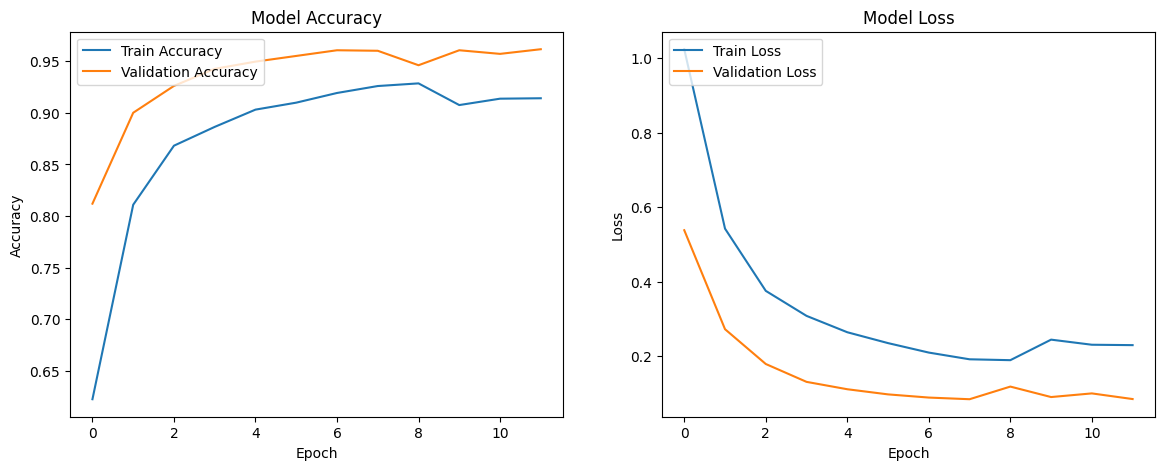

In [64]:
import matplotlib.pyplot as plt

# Assuming the model has been trained and the history object is available
# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    # Show the plots
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)


In [65]:
pred=np.argmax(model.predict(X_test),axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step


In [66]:
from sklearn.metrics import accuracy_score,classification_report
print("accuracy of model on test dataset is ",accuracy_score(pred,y_test))


accuracy of model on test dataset is  0.954


In [67]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       588
           1       0.96      0.97      0.96       690
           2       0.90      0.85      0.87       168
           3       0.95      0.99      0.97       264
           4       0.98      0.89      0.94       246
           5       0.65      0.98      0.78        44

    accuracy                           0.95      2000
   macro avg       0.90      0.94      0.92      2000
weighted avg       0.96      0.95      0.95      2000



In [68]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!",
            "i lost my friend",
            "Dogs are sitting by the door."
            ]
emotion_dict = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = np.argmax(model.predict(sentence), axis=1)
    print(f"{result} : {emotion_dict[result[0]]}\n\n")

He's over the moon about being accepted to the university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
[1] : joy


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
[3] : anger


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
[0] : sadness


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
[5] : surprise


i lost my friend
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
[0] : sadness


Dogs are sitting by the door.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[2] : love




In [27]:
import json

# Serialize the tokenizer to JSON
tokenizer_json = tokenizer.to_json()

# Save the JSON to a file
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

In [ ]:
!pip install SpeechRecognition


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 50.5 MB/s eta 0:00:00:00:0100:01


In [ ]:
import speech_recognition as sr

# Initialize the recognizer
r = sr.Recognizer()

# Audio file path
AUDIO_FILE = "/kaggle/input/indian-emotional-speech-corpora-iesc/Indian Emotional Speech Corpora (IESC)/Speaker-4/Anger/A-1-4-1.wav"

# Load audio file
with sr.AudioFile(AUDIO_FILE) as source:
    # Record the audio data
    audio_data = r.record(source)
    
    try:
        print("Recognizing speech...")
        # Use Google Speech Recognition
        text = r.recognize_google(audio_data)
        print("Speech recognized:")
        print(text)
    except sr.UnknownValueError:
        print("Could not understand audio")
    except sr.RequestError as e:
        print("Error accessing Google Speech Recognition service; {0}".format(e))


In [ ]:
sentences=["kids are talking by the door"]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = np.argmax(model.predict(sentence), axis=1)
    print(f"{result} : {emotion_dict[result[0]]}\n\n")